# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *Aur Marina Iuliana*

**Matricola**: *1809715*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

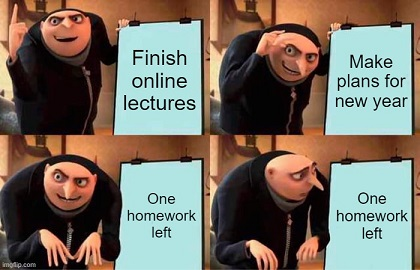

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

**Hyperpartisan News Detection** is a binary Natural Language Processing (NLP) classification task designed to detect if a given news article text follows a *hyperpartisan argumentation*. This type of argumentation is characterized by blind and prejudiced support for a specific party, faction, cause, or person. Specifically, given a text, the aim of the task is to analyze its content and classify it as either hyperpartisan ($True$ label) or non-hyperpartisan ($False$ label).

The dataset was uploaded from [HuggingFace](https://huggingface.co/datasets/SemEvalWorkshop/hyperpartisan_news_detection) and was created for [SemEval-2019](https://aclanthology.org/S19-2145/) competition. It consists of a training and a validation set, with 600,000 and 150,000 samples respectively. However, due to time and memory constraints, only **20,000 samples** from the training set were considered for this work. This decision was also made considering that NLP transformer models perform better with *sufficiently large datasets*.


    Example of one sample in the dataset:

    {
    "text": "\"<p>This is a sample article which will contain lots of text</p>\\n
    "title": "Example article 4",
    "hyperpartisan": False,
    "url": "https://example.com/example4"
    "published_at": "2020-01-01",
    "bias": 1
    }

In [4]:
# TODO: Insert all code here.

#### Set Up

In [5]:
# Import Packages
# !pip install keras_nlp
# !pip install wordcloud lazypredict
# !pip install transformers datasets

In [6]:
# Import Libraries
import numpy as np
import pandas as pd
from datasets import load_dataset
from wordcloud import WordCloud
import re
from html import unescape

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

from tensorflow import keras
from keras import backend as K
import keras_nlp

import time
import resource
import math

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Load dataset from Hugging Face
dataset = load_dataset("SemEvalWorkshop/hyperpartisan_news_detection", "bypublisher", trust_remote_code = True)

# Select the first 20000 samples from the train split of the dataset due to time and memory constraints
dataset = dataset['train'].select(range(20000))

Generating train split:   0%|          | 0/600000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150000 [00:00<?, ? examples/s]

In [8]:
# Preview of the dataset
dataset

Dataset({
    features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
    num_rows: 20000
})

In [9]:
# Dataset description
dataset = pd.DataFrame(dataset)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           20000 non-null  object
 1   title          20000 non-null  object
 2   hyperpartisan  20000 non-null  bool  
 3   url            20000 non-null  object
 4   published_at   20000 non-null  object
 5   bias           20000 non-null  int64 
dtypes: bool(1), int64(1), object(4)
memory usage: 800.9+ KB


In [10]:
dataset.head()

,text,title,hyperpartisan,url,published_at,bias
0,<p>When explaining her decision to reevaluate ...,After DeVos Announced Plans To Reexamine Title...,True,https://dailywire.com/news/20858/after-devos-a...,2017-09-10,0
1,<p>A Florida university will honor Trayvon Mar...,University To Award Trayvon Martin With Posthu...,True,https://dailywire.com/news/16103/university-aw...,2017-05-05,0
2,<p>Nov. 15 (UPI) &#8212; Texas State Universit...,Texas State University suspends Greek life aft...,False,https://newsline.com/texas-state-university-su...,2017-11-15,1
3,<p>Against the backdrop of an increasingly pol...,Jewish Organization's Huge Day Of Unity On Tue...,True,https://dailywire.com/node/9485,2016-09-26,0
4,<p>President-elect Donald Trump has reached an...,"BREAKING: Trump Reaches Agreement To Keep 1,00...",True,https://dailywire.com/news/11184/breaking-trum...,2016-11-29,0


#### Preprocessing

Given that even common words (*stopwords*) and punctuation can contain important information for recognizing patterns in the data, we chose a **"soft" preprocessing approach**, removing only HTML tags and URLs from the text.

In [11]:
def preprocessing(text):
  # Replace ascii characters with special characters for better visualization
  clean_text = unescape(text)
  # Remove HTML tags
  clean_text = re.sub(r'<[^>]+>', '', clean_text)
  # Remove URLs
  clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', clean_text)
  return clean_text

In [12]:
# Clean text using preprocessing function
dataset['clean_text'] = dataset['text'].apply(preprocessing)

In [13]:
print("Example of one sample from the dataset after preprocessing: \n\n", dataset['clean_text'][0], "\n")

Example of one sample from the dataset after preprocessing: 

 When explaining her decision to reevaluate Title IX guidelines as they pertain to sexual assault on college campuses, Secretary of Education Betsy DeVos said: “Every survivor of sexual misconduct must be taken seriously. Every student accused of sexual misconduct must know that guilt is not predetermined.” 

The Obama administration’s changes to Title IX have been criticized for, among other things, substantially lowering the burden of proof as it pertains to sexual assault, as well as denying elements of due process to the accused. 

However, many progressives are lashing out at DeVos because they hate her, and also rape culture and stuff. 

Perhaps the most grotesque attack came when Rob Ranco, a Texas attorney, tweeted Friday that “I'm not wishing for it … but I'd be ok if #BetsyDevos was sexually assaulted. #Sexual Assault #TitleIX.” 

The Washington Times reports that in several other tweets (condensed for this publica

#### Exploratory Data Analysis (EDA)

An exploratory data analysis (EDA) was conducted to gain insights into the data. Firstly, **WordCloud** library was used to provide a visual representation of the most common non-hyperpartisian and hyperpartisian words in the news text.

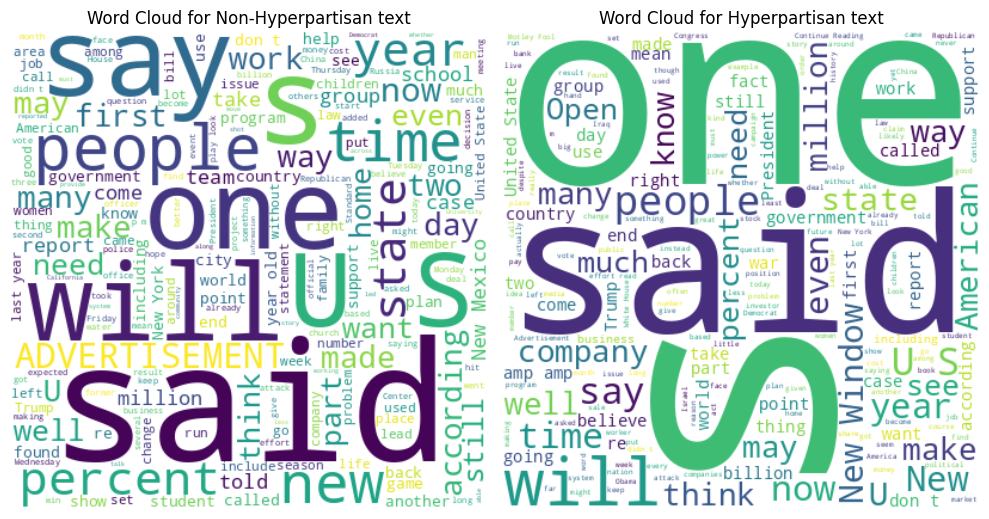

In [14]:
# Extract Hyperpartisan text
non_hyperpartisian_data = dataset[dataset['hyperpartisan'] == 0]['clean_text']
non_hyperpartisian_text = ' '.join(non_hyperpartisian_data)

# Extract Non-Hyperpartisan text
hyperpartisian_data = dataset[dataset['hyperpartisan'] == 1]['clean_text']
hyperpartisian_text = ' '.join(hyperpartisian_data)

# Generate WordCloud images
wordcloud_0 = WordCloud(width = 400, height = 400, background_color = 'white').generate(non_hyperpartisian_text)
wordcloud_1 = WordCloud(width = 400, height = 400, background_color = 'white').generate(hyperpartisian_text)

plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_0, interpolation = "bilinear")
plt.axis('off')
plt.title('Word Cloud for Non-Hyperpartisan text')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Hyperpartisan text')

plt.tight_layout()
plt.show()

hyperpartisan
True     10017
False     9983
Name: count, dtype: int64 



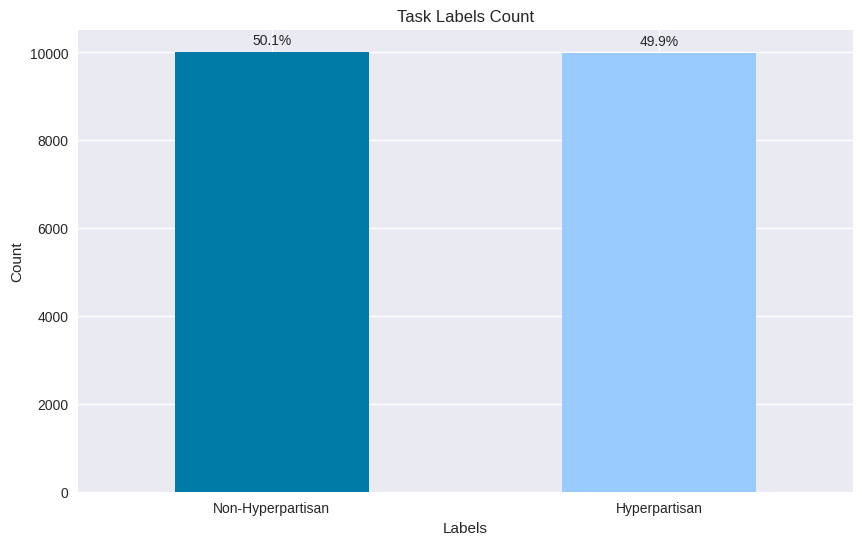

In [15]:
# Check for inconsistencies in labels count
label_counts = dataset['hyperpartisan'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100
print(label_counts, "\n")

# Plot the bar chart
plt.style.use('seaborn')
plt.figure(figsize = (10, 6))
label_counts.plot(kind = 'bar', color=["#007BA7", "#99CBFF"])
plt.title('Task Labels Count')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(ticks = [0, 1], labels = ['Non-Hyperpartisan', 'Hyperpartisan'], rotation = 0)

# Add percentage above bars
for i, (count, percentage) in enumerate(zip(label_counts, label_percentages)):
  plt.text(i, count + max(label_counts) * 0.01, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()

The Figure offers insights into *label frequency* and allows us to check for *class inconsistencies* in the task.
It shows that the two classes are **perfectly balanced**.

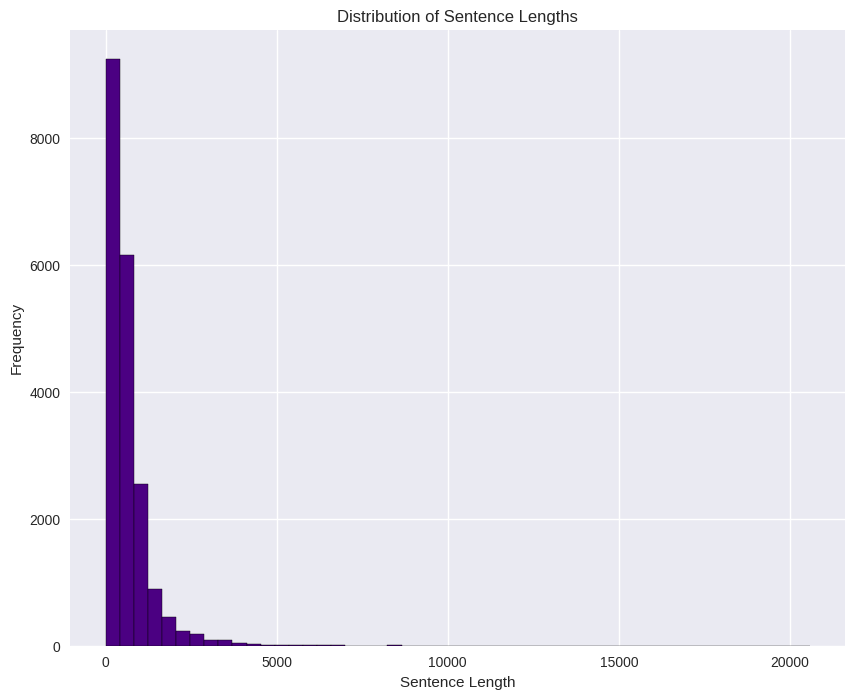

In [16]:
# Plot of the distribution of sentences length
dataset['text_length'] = dataset['clean_text'].apply(lambda x: len(x.split()))

plt.style.use('seaborn')
plt.figure(figsize = (10, 8))
plt.hist(dataset['text_length'], bins = 50, color = '#4b0082', edgecolor = 'black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

The Figure offers insight into the **distribution of sentence lengths**, showing that the majority of sentences in the news text contain fewer than 3,000 characters.

#### Split the data

In [17]:
# Split data into train, validation and test sets
X = dataset['clean_text']
Y = dataset['hyperpartisan']

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.7, random_state = 42)

In [18]:
# Print the split sizes
print("Train dataset size: ", len(X_train)) # 70%
print("Validation dataset size: ", len(X_val)) # 9%
print("Test dataset size: ", len(X_test)) # 21%

Train dataset size:  14000
Validation dataset size:  1800
Test dataset size:  4200


### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

For this section, the main reference was the guide on [Parameter-efficient fine-tuning of GPT-2 with LoRA](https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/) from Keras documentation.

Large Language Models (LLMs) are often *high-dimensional* and *over-parametrized*, while the information encoded in them tends to be well-approximated in a much lower dimension ([lottery ticket hypothesis](https://arxiv.org/abs/1803.03635)). Low-Rank Adaptation (LoRA) is a **Parameter-Efficient Fine-Tuning (PEFT)** technique based on the idea that updates to the weights of LLMs have a low "intrinsic rank". It involves freezing the weights of the model and calculating **low-rank matrices** such that:

$$
W_0 + \Delta W = W_0 + BA
$$

where:
- $W_0$ represents the weight matrix of the original dense layer.
- $A$ and $B$ are the low-rank matrices, where $B \in \mathbb{R}^{d \times r}$ and $A \in \mathbb{R}^{r \times k}$.
- $r$ denotes the rank of these matrices, with  $r > 0 $ and $r \ll min(d, k)$ (values between 1 and 4 are shown to work well).

When training updates are approximately low-rank, matrices $A$ and $B$ can closely approximate the true update.

**Low-rank approximation** decomposes a large matrix into a product of lower-dimensional matrices, effectively reducing the number of parameters requiring fine-tuning (*proxy paramters*). This reduction in parameters results in a decrease in training time and GPU memory usage, while preserving the quality of the outputs.

In [19]:
# TODO: Your code here.

In [20]:
# Check if GPU is available
device = tf.test.gpu_device_name()
print("Current device: ", device)

Current device:  /device:GPU:0


#### DeBERTaV3 model

[DeBERTaV3](https://keras.io/api/keras_nlp/models/deberta_v3/deberta_v3_classifier/) is an advanced pre-trained Large Language Model (LLM), which improves the BERT and RoBERTa models using *disentangled attention mechanism* and *enhanced mask decoder*.

The DeBERTaV3 model was chosen for this task due to its optimal performance in NLP classification tasks and its capability to handle long text sequences effectively. Specifically, `deberta_v3_extra_small_en` model, a 12-layer variant of DeBERTaV3 with maintained case sensitivity, was uploaded from Keras library due to time and memory constrains. It was trained on English Wikipedia, BookCorpus and OpenWebText.

The model has a total of **70.68 million trainable parameters**,
making the Parameter-efficient Fine-tuning (PEFT) technique a suitable choice for improvement.

In [ ]:
# Initialize a preprocessor and a DeBERTaV3 model
model_name = "deberta_v3_extra_small_en"
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(model_name) # tokenizes and packs inputs
model = keras_nlp.models.DebertaV3Classifier.from_preset(model_name, preprocessor = preprocessor, num_classes = 2)

In [22]:
# Summary of the model characteristics
model.summary()

Preprocessor: "deberta_v3_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ deberta_v3_tokenizer (DebertaV3Tokenizer)          │                                             128,001 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "deberta_v3_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ deberta_v3_backbone           │ (None, None, 384)         │      70,682,112 │ padding_mask[0][0],        │
│ (DebertaV3Backbone)           │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 384)               │               0 │ deberta_v3_backbone[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 384)               │               0 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 384)               │         147,840 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 384)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │             770 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 70,830,722 (270.20 MB)

 Trainable params: 70,830,722 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

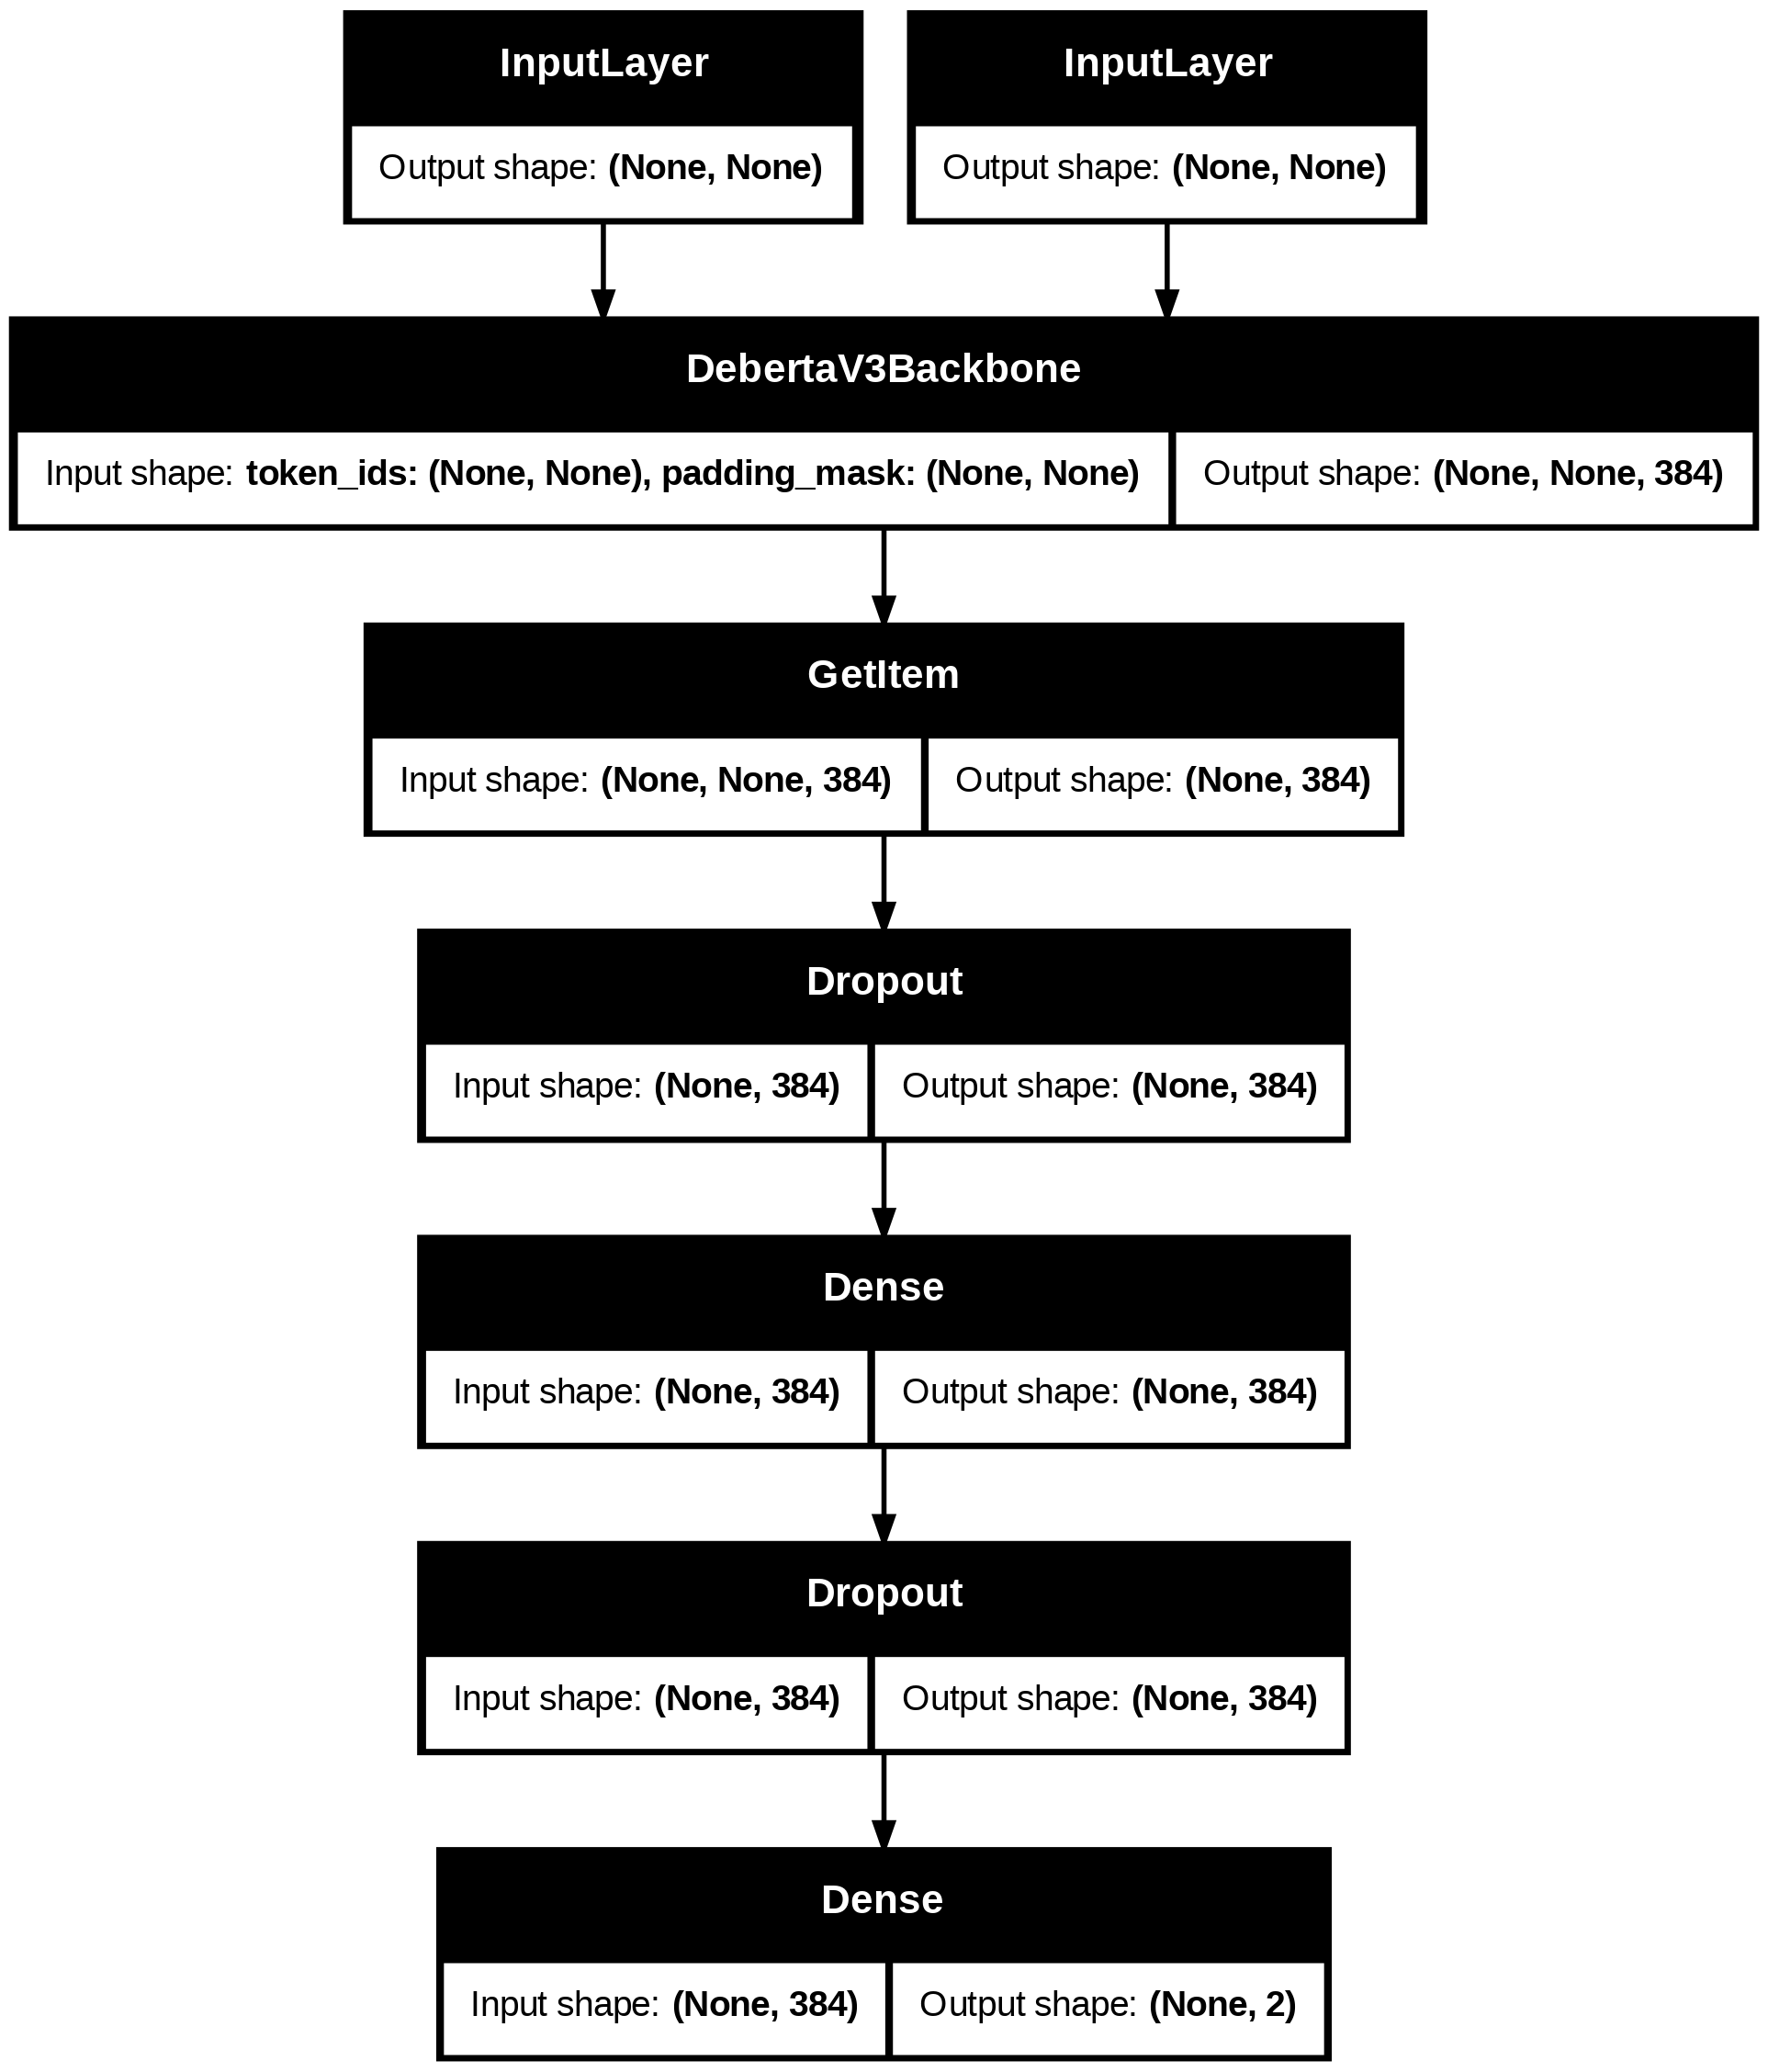

In [23]:
# Visualize the model architecture
tf.keras.utils.plot_model(model, show_shapes = True)

In [24]:
# Generate TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(8)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)

# Use cache and prefetch to improve performances during training
train_dataset = train_dataset.cache().prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [25]:
# Compile the model
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 5e-5, weight_decay = 0.001),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              weighted_metrics = ["accuracy"])

The model was trained using the [Adam optimizer](https://keras.io/api/optimizers/adamw/) and the [Sparse Categorical Cross-Entropy loss criterion](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class), as they are commonly recognized as optimal choices for classification tasks. A **low learning rate** of 0.00005 was chosen to preserve the model's features extraction capabilities.

In [26]:
# Monitor the start time and memory usage
start_time = time.time()
start_memory_usage = tf.config.experimental.get_memory_info('GPU:0') # current memory used by the device, in bytes

# Fit the model on the train and validation datasets
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 3
)

# Monitor the end time and memory usage
end_time = time.time()
end_memory_usage = tf.config.experimental.get_memory_info('GPU:0')

Epoch 1/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1043s 447ms/step - accuracy: 0.8337 - loss: 0.3650 - sparse_categorical_accuracy: 0.8337 - val_accuracy: 0.9422 - val_loss: 0.1613 - val_sparse_categorical_accuracy: 0.9422
Epoch 2/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 776s 443ms/step - accuracy: 0.9309 - loss: 0.1743 - sparse_categorical_accuracy: 0.9309 - val_accuracy: 0.9483 - val_loss: 0.1362 - val_sparse_categorical_accuracy: 0.9483
Epoch 3/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 778s 445ms/step - accuracy: 0.9542 - loss: 0.1186 - sparse_categorical_accuracy: 0.9542 - val_accuracy: 0.9494 - val_loss: 0.1639 - val_sparse_categorical_accuracy: 0.9494


In [27]:
# Calculate the total time and the total memory usage for the training
total_time = end_time - start_time
total_memory_usage = end_memory_usage['current'] - start_memory_usage['current']

print("Total time needed for training DeBERTaV3: ", round(total_time/60, 3), "minutes")
print("Total memory usage of DeBERTaV3: ", round(total_memory_usage/(1024 ** 2), 3), "MB")

Total time needed for training DeBERTaV3:  43.693 minutes
Total memory usage of DeBERTaV3:  625.768 MB


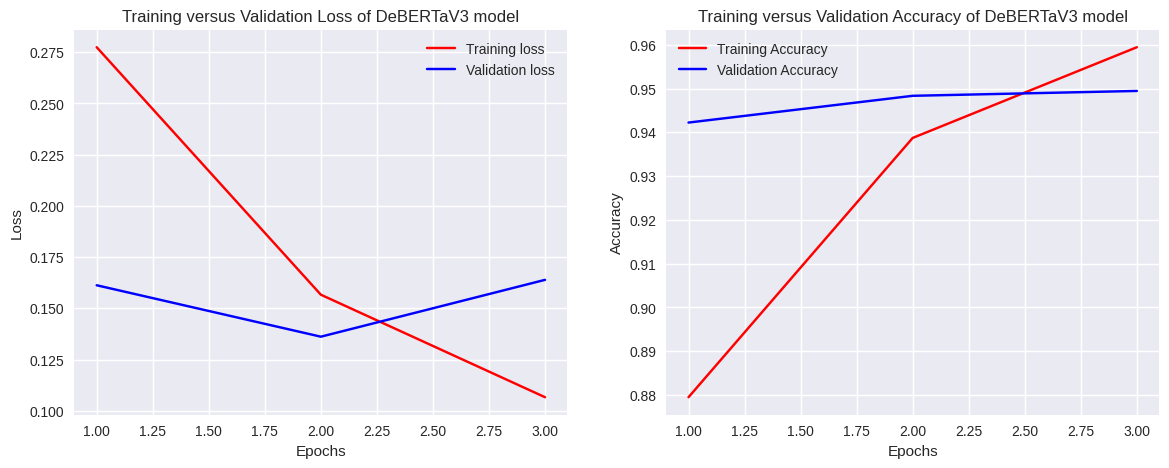

In [28]:
# Data Extraction from Train History
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))

# Compare Training versus Validation loss
ax1.plot(epochs, train_loss, 'r', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training versus Validation Loss of DeBERTaV3 model')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Compare Training versus Validation accuracy
ax2.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
ax2.set_title('Training versus Validation Accuracy of DeBERTaV3 model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

This behaviour could be an indicator of **overfitting** and a **poor generalization capability** of the model.

In [29]:
# Evaluate the performance of the model on the test dataset
eval_result = model.evaluate(test_dataset)

# Compute Precision, Recall and F1-score metrics
y_true = np.concatenate([y for x, y in test_dataset], axis = 0)
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis = -1)

precision = precision_score(y_true, y_pred, average = 'weighted')
recall = recall_score(y_true, y_pred, average = 'weighted')
f1 = f1_score(y_true, y_pred, average = 'weighted')

# Visualize metrics
metrics = {
    "Model": "DeBERTaV3",
    "Loss": eval_result[0],
    "Accuracy": eval_result[1],
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
}

metrics_df = pd.DataFrame(metrics, index = [0])
metrics_df = metrics_df.set_index("Model")
metrics_df

525/525 ━━━━━━━━━━━━━━━━━━━━ 75s 141ms/step - accuracy: 0.9429 - loss: 0.1698 - sparse_categorical_accuracy: 0.9429
525/525 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step


,Loss,Accuracy,Precision,Recall,F1-score
Model,,,,,
DeBERTaV3,0.169415,0.941429,0.942052,0.941429,0.941415


#### Parameter-Efficient Fine-Tuning (PEFT) with Low-Rank Adaptation (LoRA)

In [30]:
# Reference for the code: https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/
# Create a LoRA layer
class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        trainable=False,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        # Original dense layer should be frozen
        self.original_layer = original_layer
        self.original_layer.trainable = False

        # LoRA dense layers
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            kernel_initializer = keras.initializers.VarianceScaling(
                scale = math.sqrt(5), mode = "fan_in", distribution = "uniform"
            ),
            trainable = trainable,
            name = f"lora_A",
        )
        # B has the same 'equation' and 'output_shape' as the original layer.
        # 'equation = abc, cde -> abde', where 'a': 'batch size', 'b': 'sequence
        # length', 'c': 'hidden_dim', 'd': 'num_heads',
        # 'e': 'hidden_dim//num_heads'. The only difference is that in layer 'B',
        # 'c' represents 'rank'
        self.B = keras.layers.EinsumDense(
            equation=original_layer_config["equation"],
            output_shape=original_layer_config["output_shape"],
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"lora_B",
        )

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights
        return original_output

In [ ]:
# Load the original model
lora_model = keras_nlp.models.DebertaV3Classifier.from_preset(
    model_name,
    preprocessor = preprocessor,
    num_classes = 2
)

In [32]:
# LoRA injection into DeBERTV3 model
# Override the original query/value projection matrices with our new LoRA layers
for layer_idx in range(lora_model.backbone.num_layers):
    # Change query dense layer
    decoder_layer = lora_model.backbone.get_layer(f"disentangled_attention_encoder_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer
    # Allow mutation to Keras layer state
    self_attention_layer._tracker.locked = False

    # Change query dense layer
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=4, # values between 1 and 4 are shown to work well
        trainable=True,
    )

    # Change value dense layer
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=4, # values between 1 and 4 are shown to work well
        trainable=True,
    )

In [33]:
# Make sure we still have a valid chain of computation
lora_model(preprocessor(["LoRA is very useful for quick LLM finetuning"]))
pass

In [34]:
# Freeze the entire model, only the LoRA layers should be trainable
for layer in lora_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())

    if len(lst_of_sublayers) == 1:  # "leaves of the model"
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

In [35]:
# Model summary with LoRA injection
lora_model.summary()

Preprocessor: "deberta_v3_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ deberta_v3_tokenizer (DebertaV3Tokenizer)          │                                             128,001 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "deberta_v3_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ deberta_v3_backbone           │ (None, None, 384)         │      70,755,840 │ padding_mask[0][0],        │
│ (DebertaV3Backbone)           │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 384)               │               0 │ deberta_v3_backbone[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 384)               │               0 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 384)               │         147,840 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 384)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │             770 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 70,904,450 (270.48 MB)

 Trainable params: 270,336 (1.03 MB)

 Non-trainable params: 70,634,114 (269.45 MB)

After PEFT, DeBERTaV3 has only **270,000 trainable parameters** compared to 70 million of the original model.

In [36]:
# Compile the model with LoRA
lora_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 5e-5, weight_decay = 0.001),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              weighted_metrics = ["accuracy"])

In [37]:
# Monitor the start time and memory usage
start_time_lora = time.time() # current time, in seconds
start_memory_usage_lora = tf.config.experimental.get_memory_info('GPU:0') # current memory used by the device, in bytes

# Fit the model on the train and validation datasets
history_lora = lora_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 3
)

# Save the end time and memory usage
end_time_lora = time.time()
end_memory_usage_lora = tf.config.experimental.get_memory_info('GPU:0')

Epoch 1/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 877s 381ms/step - accuracy: 0.7519 - loss: 0.4840 - sparse_categorical_accuracy: 0.7519 - val_accuracy: 0.8933 - val_loss: 0.2480 - val_sparse_categorical_accuracy: 0.8933
Epoch 2/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 719s 411ms/step - accuracy: 0.8881 - loss: 0.2688 - sparse_categorical_accuracy: 0.8881 - val_accuracy: 0.9061 - val_loss: 0.2193 - val_sparse_categorical_accuracy: 0.9061
Epoch 3/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 663s 379ms/step - accuracy: 0.9060 - loss: 0.2349 - sparse_categorical_accuracy: 0.9060 - val_accuracy: 0.9139 - val_loss: 0.2043 - val_sparse_categorical_accuracy: 0.9139


In [38]:
# Calculate the total time and the total memory usage for the training
total_time_lora = end_time_lora - start_time_lora
total_memory_usage_lora = end_memory_usage_lora['current'] - start_memory_usage_lora['current']

print("Total time needed for training DeBERTaV3 with LoRA: ", round(total_time_lora/60, 3), "minutes")
print("Total memory usage of DeBERTaV3 with LoRa: ", round(total_memory_usage_lora/(1024 ** 2), 3), "MB")

Total time needed for training DeBERTaV3 with LoRA:  37.661 minutes
Total memory usage of DeBERTaV3 with LoRa:  3.883 MB


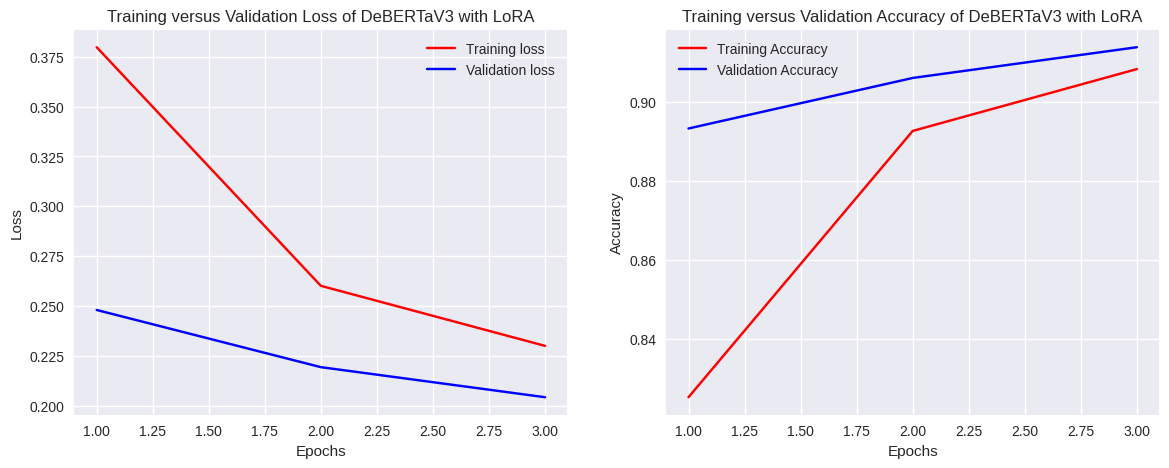

In [39]:
# Data Extraction from Train History
train_loss = history_lora.history['loss']
val_loss = history_lora.history['val_loss']
train_accuracy = history_lora.history['accuracy']
val_accuracy = history_lora.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Compare Training versus Validation loss
ax1.plot(epochs, train_loss, 'r', label = 'Training loss')
ax1.plot(epochs, val_loss, 'b', label = 'Validation loss')
ax1.set_title('Training versus Validation Loss of DeBERTaV3 with LoRA')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Compare Training versus Validation accuracy
ax2.plot(epochs, train_accuracy, 'r', label = 'Training Accuracy')
ax2.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
ax2.set_title('Training versus Validation Accuracy of DeBERTaV3 with LoRA')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

The Figure underlines the effectiveness of LoRA in fine-tuning DeBERTaV3 model, demonstrating how this tecnique **improves the generalization capability** of the model and **reduces overall overfitting**.

In [40]:
# Evaluate the performance of the model on the test dataset
eval_result = lora_model.evaluate(test_dataset)

# Compute Precision, Recall and F1-score metrics
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = lora_model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=-1)

precision = precision_score(y_true, y_pred, average = 'weighted')
recall = recall_score(y_true, y_pred, average = 'weighted')
f1 = f1_score(y_true, y_pred, average = 'weighted')

# Visualize metrics
metrics_lora = {
    "Model": "DeBERTaV3 with LoRA",
    "Loss": eval_result[0],
    "Accuracy": eval_result[1],
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
}

metrics_df_lora = pd.DataFrame(metrics_lora, index = [0])
metrics_df_lora = metrics_df_lora.set_index("Model")
metrics_df_lora

525/525 ━━━━━━━━━━━━━━━━━━━━ 78s 147ms/step - accuracy: 0.9150 - loss: 0.2223 - sparse_categorical_accuracy: 0.9150
525/525 ━━━━━━━━━━━━━━━━━━━━ 83s 143ms/step


,Loss,Accuracy,Precision,Recall,F1-score
Model,,,,,
DeBERTaV3 with LoRA,0.217477,0.916191,0.918191,0.91619,0.91611


#### Comparison

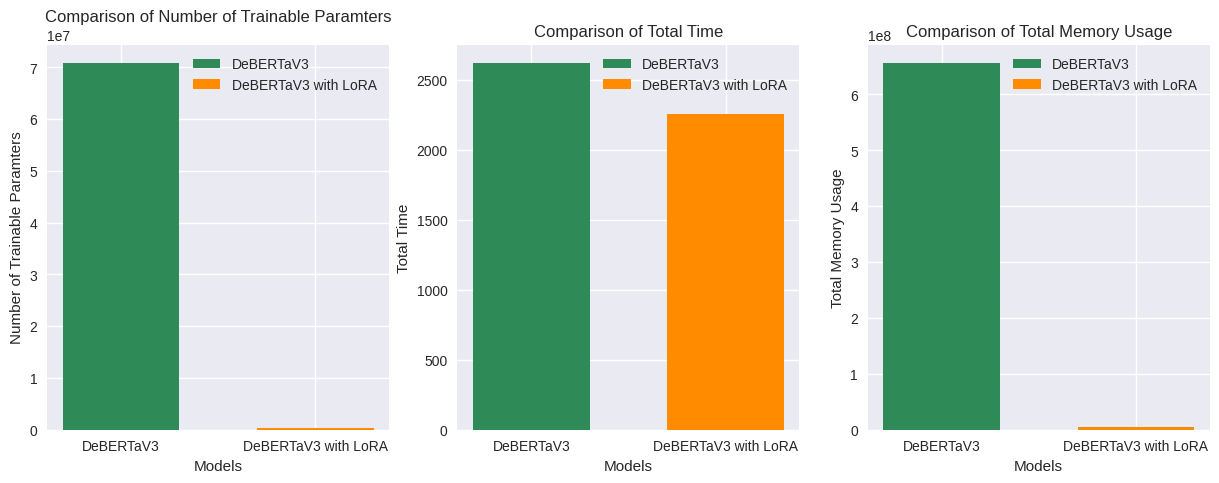

In [41]:
deberta_trainable_params_count = 70830722
lora_trainable_params_count = 270336

statistics_categories = ['Number of Trainable Paramters', 'Total Time', 'Total Memory Usage']
statistics = {
    'deberta': [deberta_trainable_params_count, total_time, total_memory_usage],
    'deberta_with_lora': [lora_trainable_params_count, total_time_lora, total_memory_usage_lora]
}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, category in enumerate(statistics_categories):
    deberta_data = statistics['deberta'][i]
    lora_data = statistics['deberta_with_lora'][i]

    bar_width = 0.5
    index = 0.5
    ax[i].bar(index - bar_width/2, deberta_data, width = 0.3, color = '#2e8b57', label='DeBERTaV3')
    ax[i].bar(index + bar_width/2, lora_data, width = 0.3, color = '#ff8c00', label='DeBERTaV3 with LoRA')

    ax[i].set_xlabel('Models')
    ax[i].set_ylabel(category)
    ax[i].set_title(f'Comparison of {category}')
    ax[i].set_xticks([index - bar_width/2, index + bar_width/2])
    ax[i].set_xticklabels(['DeBERTaV3', 'DeBERTaV3 with LoRA'])
    ax[i].legend()

plt.style.use('seaborn')
plt.show()

In [42]:
comparison_df = pd.concat([metrics_df, metrics_df_lora])
comparison_df

,Loss,Accuracy,Precision,Recall,F1-score
Model,,,,,
DeBERTaV3,0.169415,0.941429,0.942052,0.941429,0.941415
DeBERTaV3 with LoRA,0.217477,0.916191,0.918191,0.916190,0.916110


Based on these statistics, we can conclude that fine-tuning DeBERTaV3 model with LoRA has produced **notably good results**. Firstly, there is a significant reduction in the number of trainable parameters, decreasing from 70 million to 270,000. This reduction has resulted in shorter total training time and reduced memory usage.

Despite the metrics in the table show a slight decrease when comparing the model without and with fine-tuning, the overall performance remains satisfactory. Moreover, as mentioned before, the DeBERTaV3 model shows a tendency to overfit, while the fine-tuning with LoRA mitigates this tendency and improves its capability to generalize new unseen data.

Further investigations may include hyperparameter tuning of the rank parameter $r$ and scaling parameter $\alpha$ in LoRA, resulting in a trade-off between model size, computational considerations and overall performance.

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

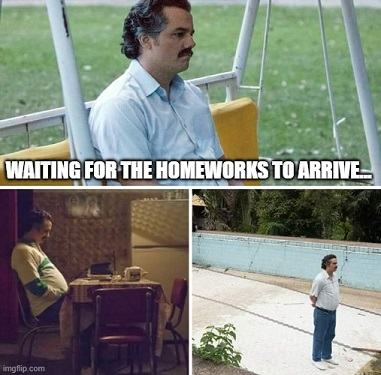